Load Glutamatergic Data

In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

data_path = "E:/Marmoset_V1/P0/"

sample_IDs = ["S1", "S2", "S3", "S4"]

adata = sc.read_h5ad(data_path + "Marmoset_V1_P0_Glut.h5ad")
adata

AnnData object with n_obs × n_vars = 47624 × 19095
    obs: 'batch', 'species', 'n_genes', 'percent_mito', 'n_UMIs', 'doublet', 'doublet_score', 'n_counts', 'leiden', 'class'
    var: 'gene_ids', 'feature_types'

Analyze Glutamatergic Cells

In [2]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)


2023-06-13 15:44:56,693 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-13 15:45:09,515 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-13 15:45:09,869 - harmonypy - INFO - Iteration 1 of 20
2023-06-13 15:45:34,788 - harmonypy - INFO - Iteration 2 of 20
2023-06-13 15:45:59,857 - harmonypy - INFO - Iteration 3 of 20
2023-06-13 15:46:22,535 - harmonypy - INFO - Iteration 4 of 20
2023-06-13 15:46:31,058 - harmonypy - INFO - Iteration 5 of 20
2023-06-13 15:46:39,603 - harmonypy - INFO - Iteration 6 of 20
2023-06-13 15:46:48,172 - harmonypy - INFO - Iteration 7 of 20
2023-06-13 15:46:56,739 - harmonypy - INFO - Iteration 8 of 20
2023-06-13 15:47:05,308 - harmonypy - INFO - Iteration 9 of 20
2023-06-13 15:47:30,287 - harmonypy - INFO - Iteration 10 of 20
2023-06-13 15:47:45,417 - harmonypy - INFO - Iteration 11 of 20
2023-06-13 15:47:54,034 - harmonypy - INFO - Iteration 12 of 20
2023-06-13 15:48:02,604 - harmonypy - INFO - Iteration 13 of

computing neighbors


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:39)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


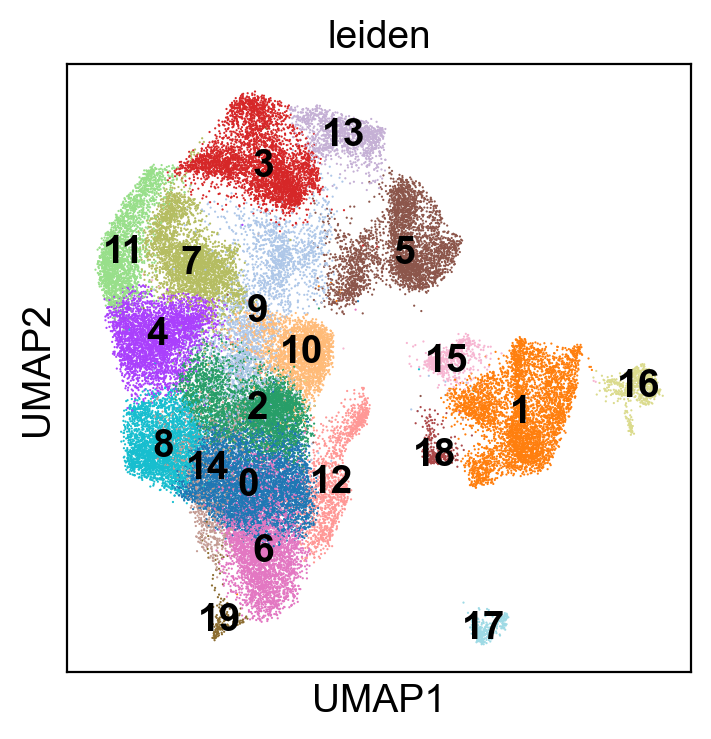

In [3]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "batch", max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


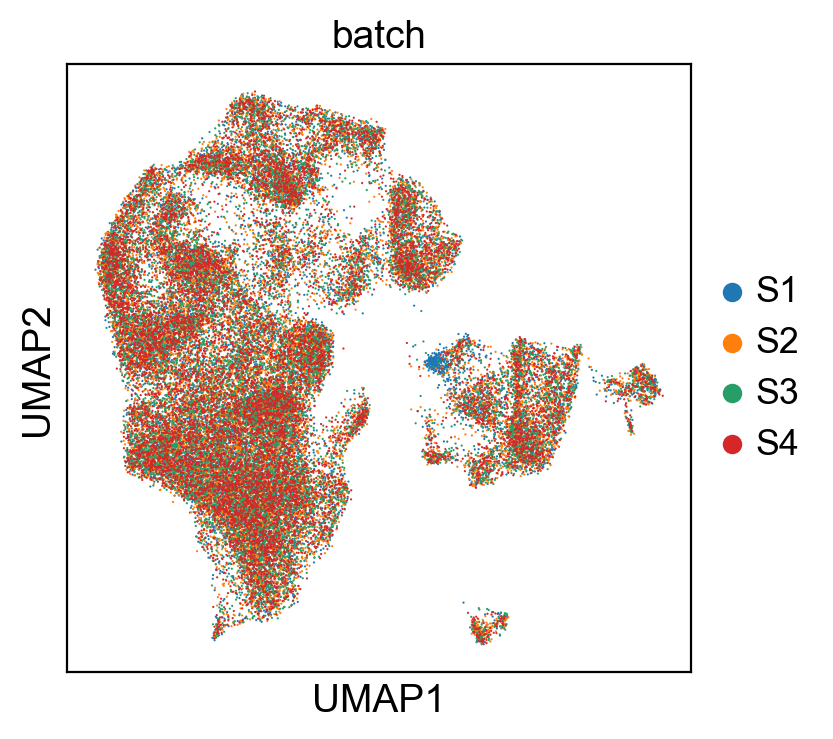

In [4]:
sc.pl.umap(adata, color=["batch"])

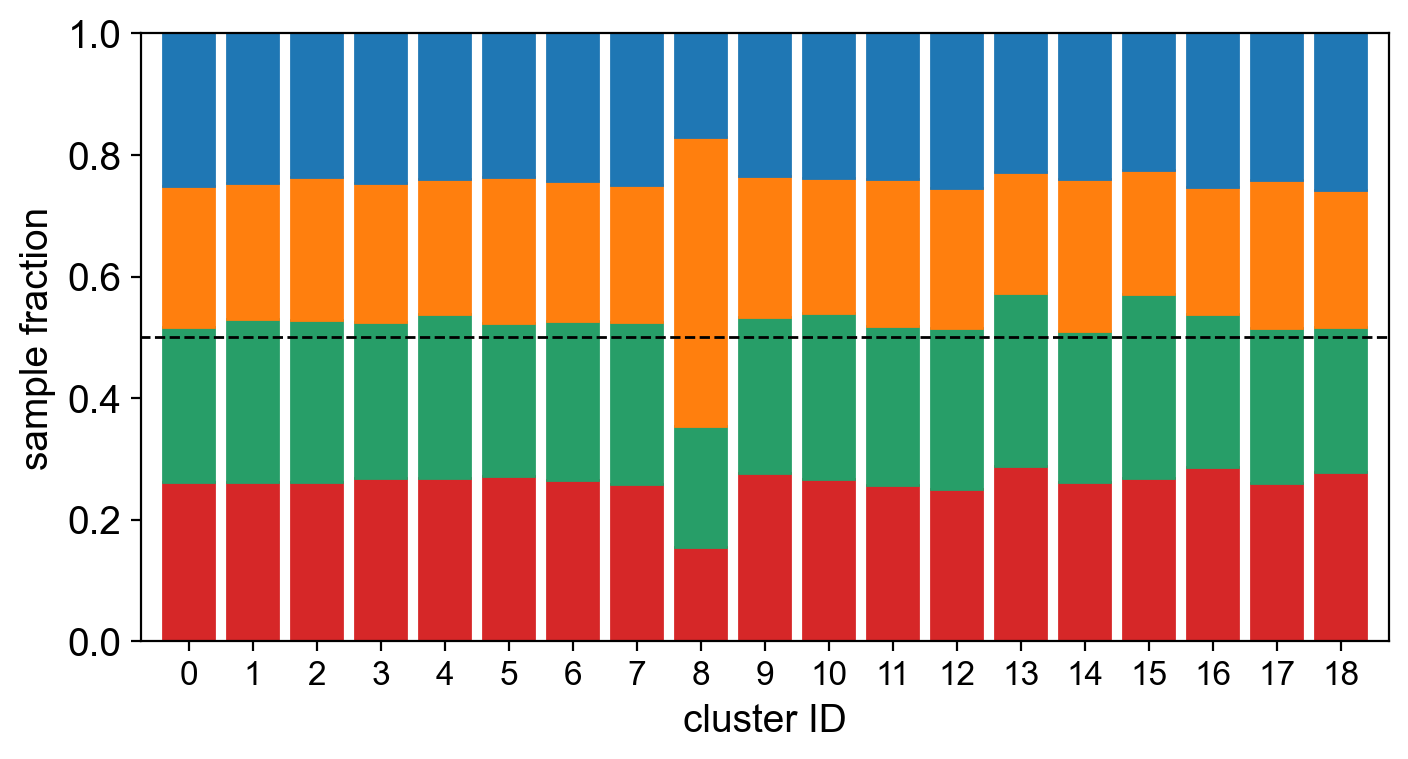

In [6]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in sample_IDs[::-1]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["batch"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["batch_colors"][::-1]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.hlines(0.5, -1, np.max(cluster_ids) + 1, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("sample fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

In [7]:
# Remove clusters if they arise from a single sample.
sample_cluster_ids = [16, 17]
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
for cluster in cluster_ids:
    if cluster in sample_cluster_ids:
        cluster_mask = adata.obs["leiden"] != str(cluster)
        adata = adata[cluster_mask, :]

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: General, 2/3, 234, etc.


C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


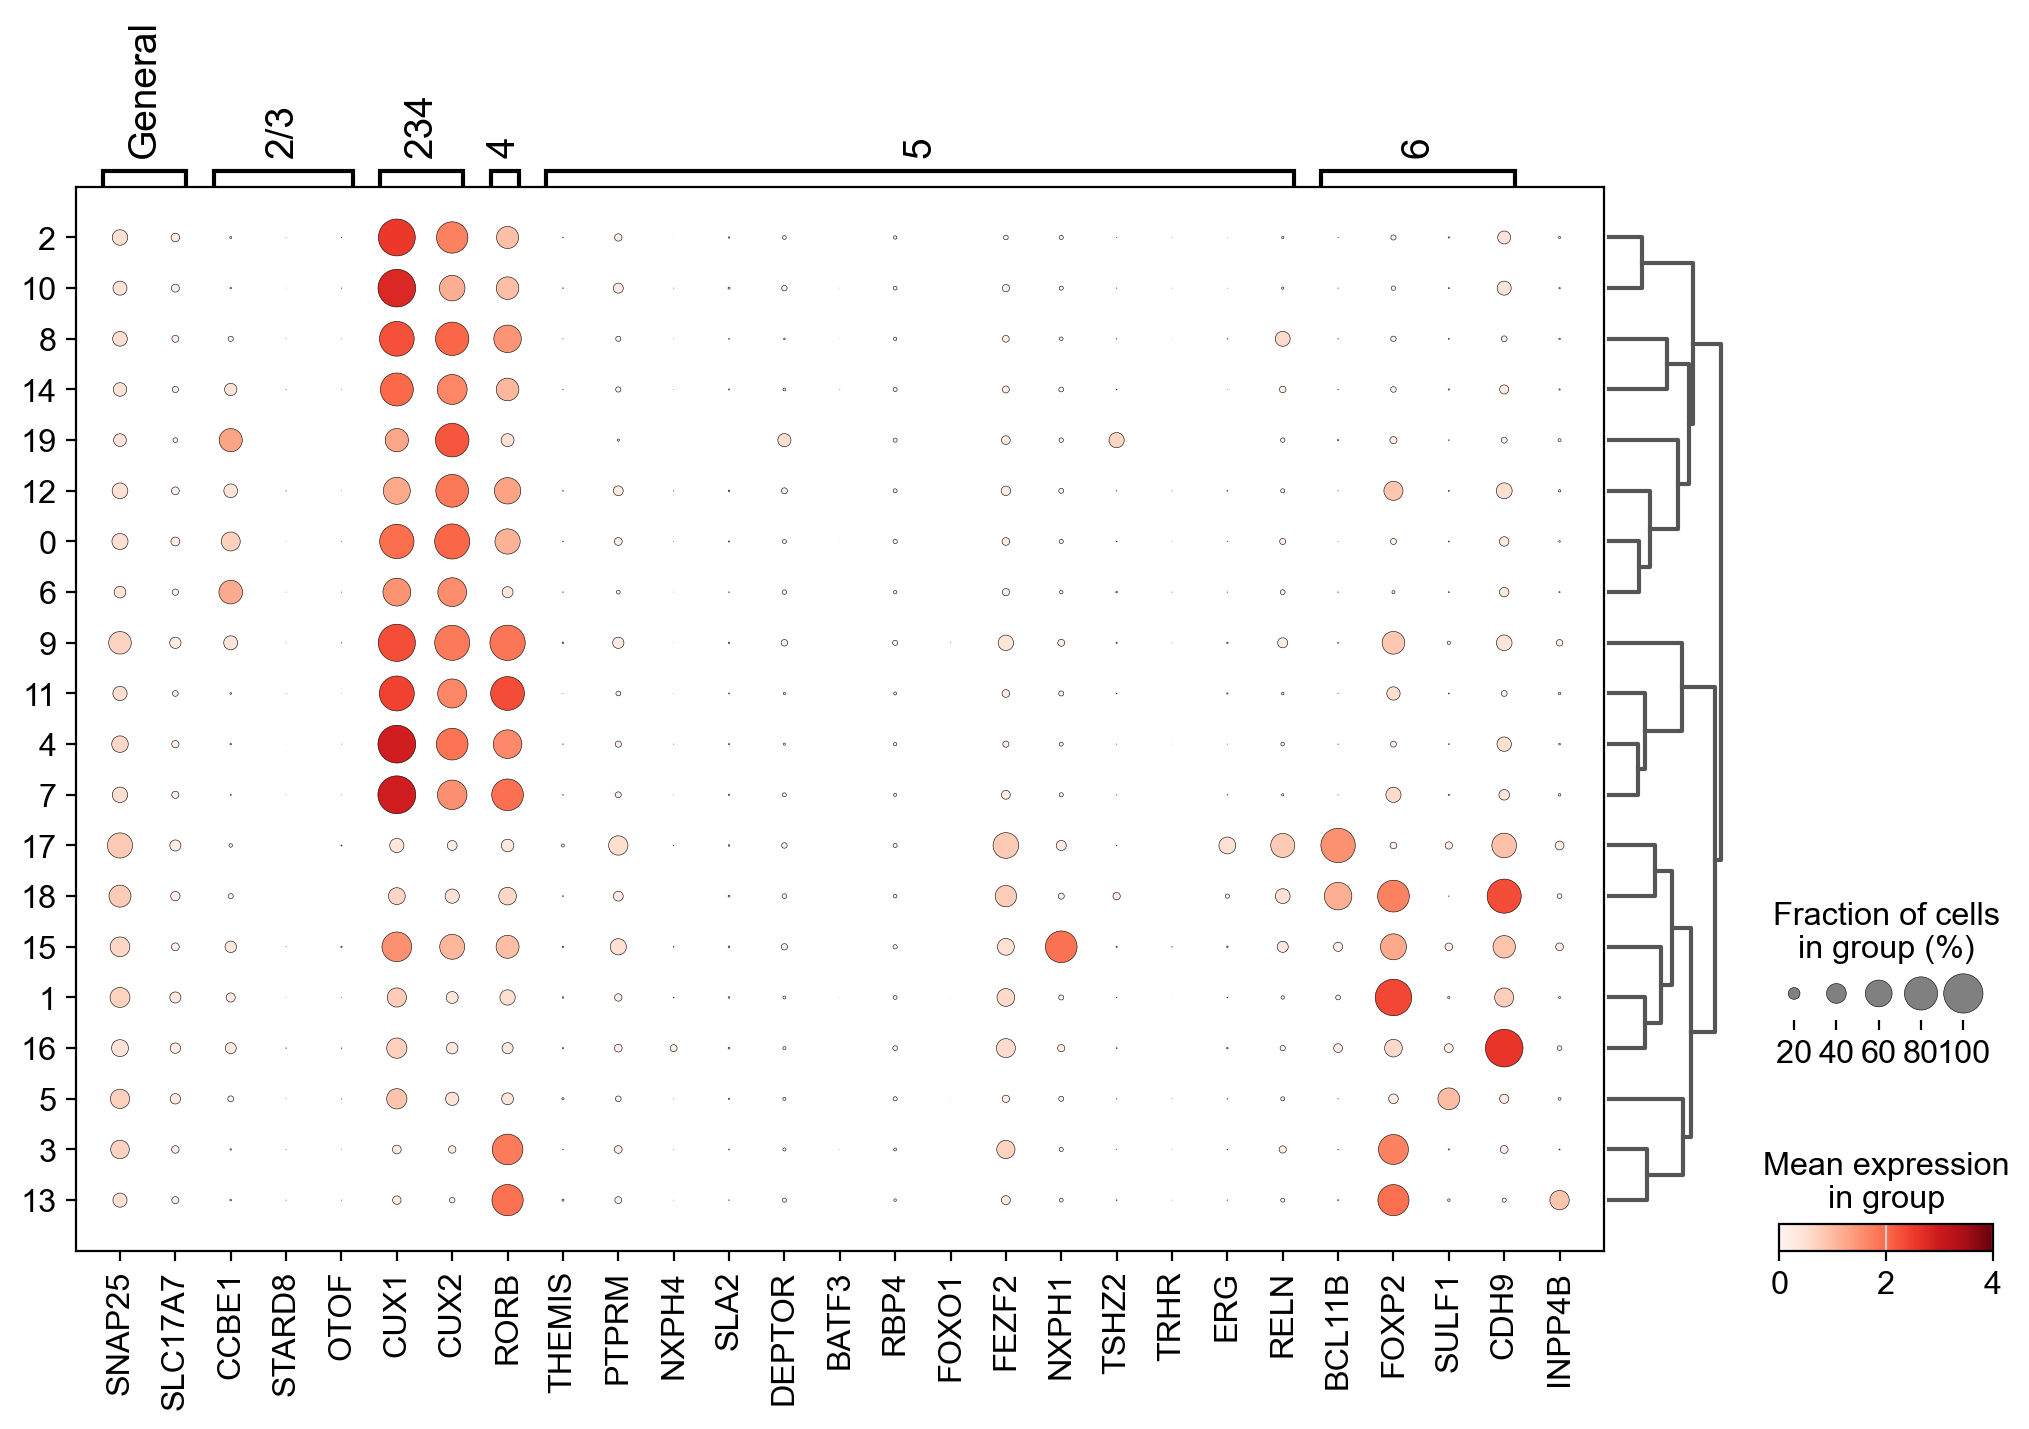

In [5]:
glutamatergic_markers = [
                         "SNAP25", "SLC17A7", # general
                         "CCBE1", "STARD8", "OTOF", # L2/3
                         "CUX1", "CUX2", # L2/3 & L4
                         "RORB", "THEMIS", # L4 "WHRN", "RSPO1",
                         "PTPRM", "NXPH4", "SLA2", 
                         "DEPTOR", "BATF3", "RBP4", "FOXO1", "FEZF2", "NXPH1", "TSHZ2", "TRHR", "ERG", "RELN", "BCL11B", # L5
                         "FOXP2", "SULF1", "CDH9", "INPP4B" # , "SVIL" # L6
                        ]

sc.pl.dotplot(
    adata, 
    glutamatergic_markers, 
    groupby="leiden", 
    dendrogram=True, 
    swap_axes=False, 
    vmin=0, vmax=4, 
    var_group_positions=[(0, 1), (2, 4), (5, 6), (7, 7), (8, 21), (22, 25)], 
    var_group_labels=["General", "2/3", "234", "4", "5", "6"], 
            )

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


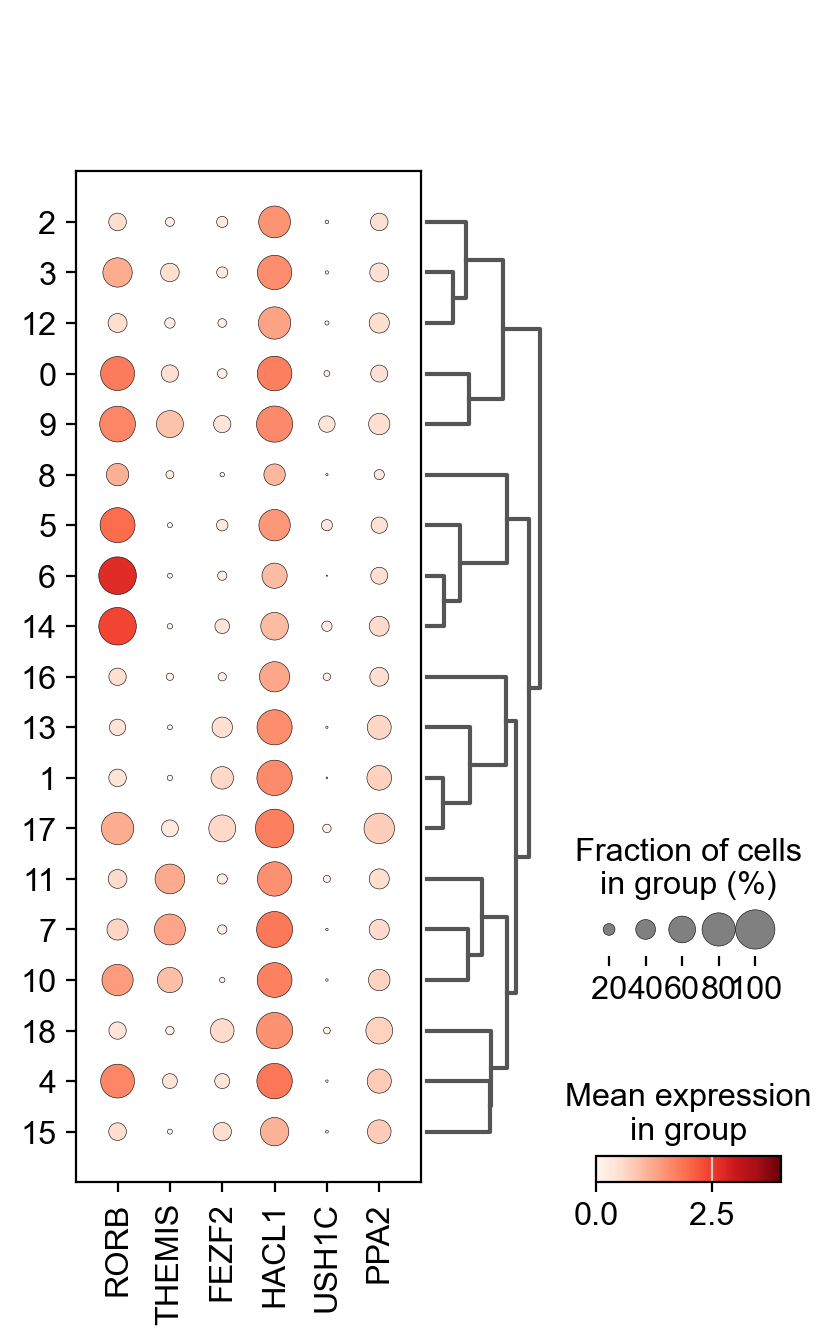

In [14]:
glutamatergic_markers = [
                         "RORB", "THEMIS", "FEZF2", 
                         "HACL1", "USH1C", "PPA2"
                        ]

sc.pl.dotplot(
    adata, 
    glutamatergic_markers, 
    groupby="leiden", 
    dendrogram=True, 
    swap_axes=False, 
    vmin=0, vmax=4, 
    # var_group_positions=[(0, 1), (2, 4), (5, 6), (7, 7), (8, 21), (22, 25)], 
    # var_group_labels=["General", "2/3", "234", "4", "5", "6"], 
            )

Save Clustered AnnData Object

In [7]:
adata.write_h5ad(data_path + "Marmoset_V1_P0_Glut_Clustered.h5ad")